In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from scipy.integrate import simps
import os
import seaborn as sns
from tqdm import tqdm
import warnings
import re
from scipy.stats import beta
warnings.filterwarnings("ignore")



In [3]:
AUC_df_path_numerical = "../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat_instance_format.csv"
data =pd.read_csv(AUC_df_path_numerical)
data.head()

,CCL,Drug,Value
0,ACH-000011,8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6),0.999997
1,ACH-000015,8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6),0.822103
2,ACH-000018,8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6),0.952084
3,ACH-000021,8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6),0.900313
4,ACH-000027,8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6),0.986441


In [22]:
thres_df =pd.read_csv("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/LOBICO/LOBICO_AUDRC_threshold_normalSampl_normalKDE.csv")
thres_df["threshold"].describe()

count    1440.000000
mean        0.606467
std         0.133354
min        -0.193461
25%         0.583184
50%         0.654165
75%         0.689191
max         0.747963
Name: threshold, dtype: float64

count    362.000000
mean       0.359392
std        0.199501
min        0.032574
25%        0.210620
50%        0.323644
75%        0.479860
max        0.943713
Name: Value, dtype: float64


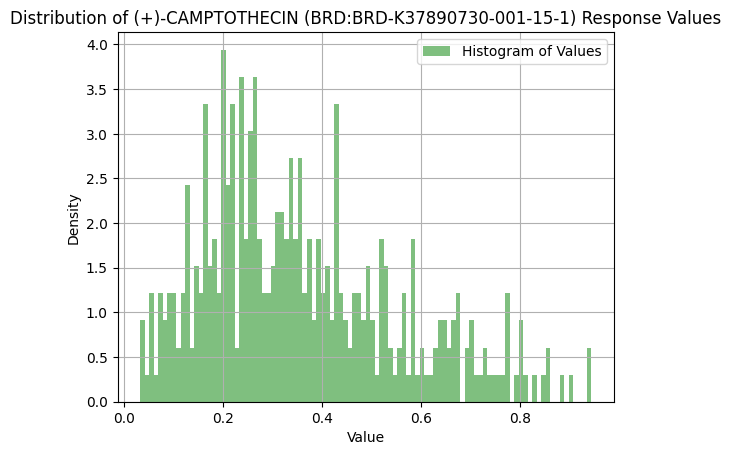

In [19]:
drugname = "(+)-CAMPTOTHECIN (BRD:BRD-K37890730-001-15-1)"
c=data[data["Drug"] == drugname]["Value"].values
print(data[data["Drug"] == drugname]["Value"].describe())
plt.hist(c, bins=100, density=True, alpha=0.5, color='g', label='Histogram of Values')
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(f"Distribution of {drugname} Response Values")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
def sanitize_filename(name):
    return re.sub(r'[\/]', '_', name) # :*?"<>|
sanitize_filename(Drug)
# ATENOLOL-(+/-) (BRD:BRD-A20239487-001-24-9)

NameError: name 'Drug' is not defined

In [ ]:
# Fixed std
fixed_std = 0.06 # 0.2
upsample_n = 1000
bandwidth = 0.5
threshold_t = 0.05
response = "AUDRC"

output_dir = "../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/LOBICO/fixed_std0.06/"
os.makedirs(output_dir, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r'[\/]', '_', name) # :*?"<>|

results = []

# Define θ-finding function
def find_theta(x, kde_vals, mu, fmin, dx):
    f_prime = np.gradient(kde_vals, dx)
    f_double_prime = np.gradient(f_prime, dx)
    f_triple_prime = np.gradient(f_double_prime, dx)

    # Rule i
    candidates_i = np.where((f_prime[:-1] * f_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_i):
        theta = x[idx]
        if kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return theta

    # Rule ii
    candidates_ii = np.where((f_double_prime[:-1] * f_double_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_ii):
        if f_triple_prime[idx] > 0 and kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return x[idx]

    return fmin  # Rule iii fallback

# Main loop
for Drug, group in tqdm(data.groupby("Drug")):
    sampled_response = []
    for value in group["Value"]:
        sampled = np.random.normal(loc=value, scale=fixed_std, size=upsample_n) # upsample n=1000　＃不包含原本的 value
        sampled_response.extend(sampled)

    sampled_response = np.array(sampled_response)
    # 對所有 upsampled 的 IC50 值做 kernel density estimation（KDE）來估計其機率密度分布。
    kde = gaussian_kde(sampled_response, bw_method=bandwidth / sampled_response.std(ddof=1)) # bandwidth 控制曲線平滑程度，這裡將它與樣本標準差相除進行縮放（調整 smoothness）。
    
    # 建立一個從最小值到最大值的等距 x 軸（1000個點），以便繪製 KDE 曲線。
    x_grid = np.linspace(sampled_response.min(), sampled_response.max(), 1000) 
    kde_vals = kde.evaluate(x_grid) # 機率密度估計值

    #找出 KDE 曲線的最大值位置，也就是 mode（主峰）的位置，記作 μ。
    mu = x_grid[np.argmax(kde_vals)]
    fmin = x_grid[0]
    dx = x_grid[1] - x_grid[0]

    theta = find_theta(x_grid, kde_vals, mu, fmin, dx)

    within_theta_mu = sampled_response[(sampled_response >= theta) & (sampled_response <= mu)]
    # σ 是 從 μ 往左看，在 [θ, μ] 區間中，所有 sample 與 μ 的距離的「中位數」
    sigma = np.median(np.abs(within_theta_mu - mu)) if len(within_theta_mu) > 0 else fixed_std
    
    new_normal_curve = norm.pdf(x_grid, loc=mu, scale=sigma)
    threshold = norm.ppf(threshold_t, loc=mu, scale=sigma)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, kde_vals, label='KDE')
    plt.plot(x_grid, new_normal_curve, linestyle=':', color='black', label='N(μ, σ²)')
    plt.axvline(mu, color='orange', linestyle='--', label='Mode (μ)')
    plt.axvline(theta, color='green', linestyle='--', label='Theta (θ)')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (t={threshold_t})')
    plt.title(f"{Drug} -\n {response} KDE with Threshold")
    plt.xlabel(response)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"{sanitize_filename(Drug)}_LOBICO__AUDRC_threshold_plot.png")
    plt.savefig(plot_path)
    plt.close()

    results.append({
        "Drug": Drug,
        "mu_mode": mu,
        "theta": theta,
        "std_sigma": sigma,
        "threshold": threshold,
        "plot_path": plot_path
    })

# Save results
results_df = pd.DataFrame(results)
csv_path = os.path.join(output_dir, "LOBICO_AUDRC_threshold_normalSampl_normalKDE.csv")
results_df.to_csv(csv_path, index=False)

100%|██████████| 1440/1440 [1:26:42<00:00,  3.61s/it]


upsampling - Beta distribution

In [ ]:
# Fixed std
fixed_std = 0.06
upsample_n = 1000
bandwidth = 0.5 # 控制 KDE 平滑程度的參數
threshold_t = 0.05
response = "AUDRC"

output_dir = "../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/LOBICO/BetaSampl_normalKDE/"
os.makedirs(output_dir, exist_ok=True)

 

results = []

# Define θ-finding function
def find_theta(x, kde_vals, mu, fmin, dx):
    f_prime = np.gradient(kde_vals, dx)
    f_double_prime = np.gradient(f_prime, dx)
    f_triple_prime = np.gradient(f_double_prime, dx)

    # Rule i
    candidates_i = np.where((f_prime[:-1] * f_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_i):
        theta = x[idx]
        if kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return theta
    # Rule ii
    candidates_ii = np.where((f_double_prime[:-1] * f_double_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_ii):
        if f_triple_prime[idx] > 0 and kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return x[idx]
            
    return fmin  # Rule iii fallback

# Main loop
for Drug, group in tqdm(data.groupby("Drug")):
    sampled_response = []
    for value in group["Value"]:
        value = np.clip(value, 1e-5, 1 - 1e-5)  # 避免無法估算 beta 分布
        var = fixed_std ** 2
        alpha = ((1 - value) / var - 1 / value) * value**2
        beta_param = alpha * (1 / value - 1)
        # 如果參數非法（例如 alpha < 0），則跳過
        if alpha <= 0 or beta_param <= 0:
            continue
        sampled = beta.rvs(alpha, beta_param, size=upsample_n) # upsample n=1000
        sampled_response.extend(sampled)

    sampled_response = np.array(sampled_response)
    # 對所有 upsampled 的 IC50 值做 kernel density estimation（KDE）來估計其機率密度分布。
    kde = gaussian_kde(sampled_response, bw_method=bandwidth / sampled_response.std(ddof=1)) # bandwidth 控制曲線平滑程度，這裡將它與"樣本標準差"相除進行縮放（調整 smoothness）。ddof=1（delta degrees of freedom）使用樣本標準差而非母體標準差
    
    # 建立一個從最小值到最大值的等距 x 軸（1000個點），以便繪製 KDE 曲線。
    x_grid = np.linspace(sampled_response.min(), sampled_response.max(), 1000) 
    kde_vals = kde.evaluate(x_grid) # 機率密度估計值

    #找出 KDE 曲線的最大值位置，也就是 mode（主峰）的位置，記作 μ。
    mu = x_grid[np.argmax(kde_vals)]
    fmin = x_grid[0]
    dx = x_grid[1] - x_grid[0]

    theta = find_theta(x_grid, kde_vals, mu, fmin, dx)

    within_theta_mu = sampled_response[(sampled_response >= theta) & (sampled_response <= mu)]
    # σ 是 從 μ 往左看，在 [θ, μ] 區間中，所有 sample 與 μ 的距離的「中位數」
    sigma = np.median(np.abs(within_theta_mu - mu)) if len(within_theta_mu) > 0 else fixed_std
    
    new_beta_curve = norm.pdf(x_grid, loc=mu, scale=sigma)
    threshold = norm.ppf(threshold_t, loc=mu, scale=sigma)#Percent Point Function（PPF），又稱為 逆累積分布函數（inverse CDF）。

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, kde_vals, label='KDE')
    plt.plot(x_grid, new_beta_curve, linestyle=':', color='black', label='Beta(alpha, beta)')
    plt.axvline(mu, color='orange', linestyle='--', label='Mode (μ)')
    plt.axvline(theta, color='green', linestyle='--', label='Theta (θ)')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (t={threshold_t})')
    plt.title(f"{Drug} -\n {response} KDE with Threshold")
    plt.xlabel(response)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"{sanitize_filename(Drug)}_LOBICO_AUDRC_threshold_plot.png")
    plt.savefig(plot_path)
    plt.close()

    results.append({
        "Drug": Drug,
        "mu_mode": mu,
        "theta": theta,
        "std_sigma": sigma,
        "threshold": threshold,
        "plot_path": plot_path
    })

# Save results
results_df = pd.DataFrame(results)
csv_path = os.path.join(output_dir, "LOBICO_AUDRC_threshold_betaSampl_normalKDE.csv")
results_df.to_csv(csv_path, index=False)

100%|██████████| 1440/1440 [1:28:31<00:00,  3.69s/it]


Beta KDE

In [ ]:
# Fixed std
fixed_std = 0.06
upsample_n = 1000
bandwidth = 0.05 # 控制 KDE 平滑程度的參數 0.5
threshold_t = 0.05
response = "AUDRC"

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

output_dir = "../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/LOBICO/BetaSampl_BetaKDE_Betappf_gridrange/"
os.makedirs(output_dir, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r'[\/]', '_', name) # :*?"<>|

results = []

# Define θ-finding function
def find_theta(x, kde_vals, mu, fmin, dx):
    f_prime = np.gradient(kde_vals, dx)
    f_double_prime = np.gradient(f_prime, dx)
    f_triple_prime = np.gradient(f_double_prime, dx)
    # Rule i
    candidates_i = np.where((f_prime[:-1] * f_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_i):
        theta = x[idx]
        if kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return theta
    # Rule ii
    candidates_ii = np.where((f_double_prime[:-1] * f_double_prime[1:] <= 0) & (x[1:] < mu))[0]
    for idx in reversed(candidates_ii):
        if f_triple_prime[idx] > 0 and kde_vals[idx] < 0.8 * max(kde_vals):
            area = simps(kde_vals[:idx], x[:idx])
            if area > threshold_t:
                return x[idx]
            
    return fmin  # Rule iii fallback

# Define Beta KDE function
def beta_kde(x, data, bandwidth=0.05, grid_size=1000):
    grid = np.linspace(data.min(), data.max(), grid_size) # 建立 KDE 的 x 軸範圍從 sampled_response.min(), sampled_response.max()# grid_size=1000 x 軸取樣點數
    kde_values = np.zeros_like(grid) #初始化 KDE 的值為全 0，長度跟 grid 一樣。最後會在這個陣列中累加每個樣本對應的 Beta 分布密度。
    for point in data:
        a = ((1 - point) / bandwidth**2 - 1 / point) * point**2
        b_param = a * (1 / point - 1)
        # Clamp to avoid invalid parameters
        if a > 0 and b_param > 0:
            kde_values += beta.pdf(grid, a, b_param)
    kde_values /= len(data)
    return grid, kde_values

# Main loop
for Drug, group in tqdm(data.groupby("Drug")):
    sampled_response = []
    for value in group["Value"]:
        value = np.clip(value, 1e-5, 1 - 1e-5)  # 避免無法估算 beta 分布
        var = fixed_std ** 2
        alpha = ((1 - value) / var - 1 / value) * value**2
        beta_param = alpha * (1 / value - 1)
        # 如果參數非法（例如 alpha < 0），則跳過
        if alpha <= 0 or beta_param <= 0:
            continue
        sampled = beta.rvs(alpha, beta_param, size=upsample_n) # upsample n=1000
        sampled_response.extend(sampled)

    sampled_response = np.array(sampled_response)
    # Perform Beta KDE 
    x_grid, kde_vals = beta_kde(x=sampled_response, data=sampled_response, bandwidth=bandwidth)

    #找出 KDE 曲線的最大值位置，也就是 mode（主峰）的位置，記作 μ。
    mu = x_grid[np.argmax(kde_vals)]
    fmin = x_grid[0]
    dx = x_grid[1] - x_grid[0]

    theta = find_theta(x_grid, kde_vals, mu, fmin, dx)

    within_theta_mu = sampled_response[(sampled_response >= theta) & (sampled_response <= mu)]
    # σ 是 從 μ 往左看，在 [θ, μ] 區間中，所有 sample 與 μ 的距離的「中位數」
    sigma = np.median(np.abs(within_theta_mu - mu)) if len(within_theta_mu) > 0 else fixed_std
    
    var = sigma ** 2
    alpha = ((1 - mu) / var - 1 / mu) * mu**2
    beta_param = alpha * (1 / mu - 1)
    threshold = beta.ppf(threshold_t, alpha, beta_param) if alpha > 0 and beta_param > 0 else mu
    new_beta_curve = beta.pdf(x_grid, alpha, beta_param) if alpha > 0 and beta_param > 0 else np.zeros_like(x_grid)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, kde_vals, label='Beta KDE')
    plt.plot(x_grid, new_beta_curve, linestyle=':', color='black', label='Resistant Beta Curve')
    # plt.hist(sampled_response, bins=20, density=True, alpha=0.3, label="Histogram")
    plt.axvline(mu, color='orange', linestyle='--', label='Mode (μ)')
    plt.axvline(theta, color='green', linestyle='--', label='Theta (θ)')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (t={threshold_t})')
    plt.title(f"{Drug} -\n {response} Beta KDE with Threshold")
    plt.xlabel(response)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"{sanitize_filename(Drug)}_LOBICO_AUDRC_threshold_plot.png")
    plt.savefig(plot_path)
    plt.close()

    results.append({
        "Drug": Drug,
        "mu_mode": mu,
        "theta": theta,
        "std_sigma": sigma,
        "threshold": threshold,
        "plot_path": plot_path
    })

# Save results
results_df = pd.DataFrame(results)
csv_path = os.path.join(output_dir, "LOBICO_AUDRC_threshold_betaSampl_betaKDE_betappf.csv")
results_df.to_csv(csv_path, index=False)

 67%|██████▋   | 967/1440 [17:37:11<7:51:30, 59.81s/it]  

In [13]:
print(pd.Series(kde_vals).describe())


count    1000.000000
mean             inf
std              NaN
min         0.000190
25%         0.000613
50%         0.007267
75%         1.207014
max              inf
dtype: float64


In [ ]:
# Fixed std
fixed_std = 0.06
upsample_n = 1000
bandwidth = 0.05 # 控制 KDE 平滑程度的參數
threshold_t = 0.05
response = "AUDRC"
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
# Simulated AUDRC data around 0.98 with slight variation
np.random.seed(0)
n = 100
audrc_samples = beta.rvs(a=98, b=2, size=n)

# Define Beta KDE function
def beta_kde(x, data, bandwidth=0.05, grid_size=1000):
    grid = np.linspace(0, 1, grid_size) # 建立 KDE 的 x 軸範圍（從 0 到 1）# grid_size=1000 x 軸取樣點數
    kde_values = np.zeros_like(grid) #初始化 KDE 的值為全 0，長度跟 grid 一樣。最後會在這個陣列中累加每個樣本對應的 Beta 分布密度。
    for point in data:
        a = ((1 - point) / bandwidth**2 - 1 / point) * point**2
        b_param = a * (1 / point - 1)
        # Clamp to avoid invalid parameters
        if a > 0 and b_param > 0:
            kde_values += beta.pdf(grid, a, b_param)
    kde_values /= len(data)
    return grid, kde_values

# Perform Beta KDE
grid, kde_vals = beta_kde(x=np.linspace(0, 1, 1000), data=audrc_samples)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(grid, kde_vals, label="Beta KDE")
plt.hist(audrc_samples, bins=20, density=True, alpha=0.3, label="Histogram")
plt.title("Beta KDE for AUDRC Samples")
plt.xlabel("AUDRC")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
std_beta=0.01
mu=0.9
variance = std_beta**2
alpha = ((1 - mu) / variance - 1 / mu) * mu**2
beta_param = alpha * (1 / mu - 1)
print(f"Beta distribution parameters: alpha={alpha}, beta={beta_param}")

Beta distribution parameters: alpha=809.0999999999999, beta=89.90000000000003


In [9]:
# pip install rpy2
from rpy2.robjects.packages import importr
robjects.r('print("Hello from R")')
# x <- c(10, 20, 30)
# mean(x)

ModuleNotFoundError: No module named 'rpy2'

In [39]:
import pandas as pd
from pathlib import Path
CURVE_FILE = Path("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/secondary-screen-dose-response-curve-parameters.csv")
df = pd.read_csv(CURVE_FILE)
df

/tmp/ipykernel_73113/1140760269.py:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CURVE_FILE)


,broad_id,depmap_id,ccle_name,screen_id,upper_limit,lower_limit,slope,r2,auc,ec50,ic50,name,moa,target,disease.area,indication,smiles,phase,passed_str_profiling,row_name
0,BRD-K71847383-001-12-5,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,2.122352,-0.022826,-0.026964,1.677789,8.415093e+06,NaN,cytarabine,ribonucleotide reductase inhibitor,"POLA1, POLB, POLD1, POLE",hematologic malignancy,"acute lymphoblastic leukemia (ALL), chronic ly...",Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Launched,True,ACH-000879
1,BRD-K71847383-001-12-5,ACH-000320,PSN1_PANCREAS,HTS002,1,1.325174,-0.237504,-0.147274,1.240300,9.643742e+00,NaN,cytarabine,ribonucleotide reductase inhibitor,"POLA1, POLB, POLD1, POLE",hematologic malignancy,"acute lymphoblastic leukemia (ALL), chronic ly...",Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Launched,True,ACH-000320
2,BRD-K71847383-001-12-5,ACH-001145,OC316_OVARY,HTS002,1,2.089350,-0.302937,0.193893,1.472333,2.776687e-02,NaN,cytarabine,ribonucleotide reductase inhibitor,"POLA1, POLB, POLD1, POLE",hematologic malignancy,"acute lymphoblastic leukemia (ALL), chronic ly...",Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Launched,True,ACH-001145
3,BRD-K71847383-001-12-5,ACH-000873,KYSE270_OESOPHAGUS,HTS002,1,1.311820,-0.209393,-0.005460,1.207160,2.654701e+00,NaN,cytarabine,ribonucleotide reductase inhibitor,"POLA1, POLB, POLD1, POLE",hematologic malignancy,"acute lymphoblastic leukemia (ALL), chronic ly...",Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Launched,True,ACH-000873
4,BRD-K71847383-001-12-5,ACH-000855,KYSE150_OESOPHAGUS,HTS002,1,1.369799,-0.277530,0.132818,1.229332,5.889041e-01,NaN,cytarabine,ribonucleotide reductase inhibitor,"POLA1, POLB, POLD1, POLE",hematologic malignancy,"acute lymphoblastic leukemia (ALL), chronic ly...",Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Launched,True,ACH-000855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700999,BRD-K96123349-236-02-8,ACH-001321,TT_THYROID,MTS010,1,0.854621,-1.496958,-0.530712,0.987409,1.130770e-03,NaN,brequinar,dihydroorotate dehydrogenase inhibitor,DHODH,NaN,NaN,Cc1c(nc2ccc(F)cc2c1C(O)=O)-c1ccc(cc1)-c1ccccc1F,Phase 2,True,ACH-001321
701000,BRD-K98572433-001-02-9,ACH-001321,TT_THYROID,MTS010,1,1.208683,-0.042449,-0.017257,1.000000,1.170971e+03,NaN,AZD8931,EGFR inhibitor,"EGFR, ERBB2, ERBB3",NaN,NaN,CNC(=O)CN1CCC(CC1)Oc1cc2c(Nc3cccc(Cl)c3F)ncnc2...,Phase 2,True,ACH-001321
701001,BRD-K99113996-001-02-0,ACH-001321,TT_THYROID,MTS010,1,3.155002,4.437808,0.894749,1.000000,4.702122e-01,NaN,AZD2014,mTOR inhibitor,MTOR,NaN,NaN,CNC(=O)c1cccc(c1)-c1ccc2c(nc(nc2n1)N1CCOC[C@@H...,Phase 2,True,ACH-001321
701002,BRD-K99616396-001-05-1,ACH-001321,TT_THYROID,MTS010,1,0.747157,-0.046875,0.014903,0.888088,5.590567e-04,NaN,motesanib,"KIT inhibitor, PDGFR tyrosine kinase receptor ...","FLT1, FLT4, KDR, KIT",NaN,NaN,"CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc12, C...",Phase 3,True,ACH-001321


In [59]:
import numpy as np
print(df["ic50"].describe())
df["ic50_clipped"] = df["ic50"].clip(lower=1e-300 ,upper=1e+300)#e-241, e+299
df["logIC50"] = np.log10(df["ic50_clipped"])
print(df["logIC50"].describe())

count    3.619120e+05
mean              inf
std               NaN
min      0.000000e+00
25%      4.186461e-01
50%      1.499405e+00
75%      3.170824e+00
max               inf
Name: ic50, dtype: float64
count    361912.000000
mean         -0.022210
std           4.279127
min        -300.000000
25%          -0.378153
50%           0.175919
75%           0.501172
max         300.000000
Name: logIC50, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [53]:
A = pd.Series([0,1e-300, 3.56e-241, 0.25, 1, 2, 100, 1.46838133079727E+299,1e+300, np.inf])

# A=A.replace({np.inf: "res"})# ignore inf because log10(inf)= inf, not a good threshold
print(A.apply(lambda x: np.log10(x) if pd.api.types.is_number(x) and np.isfinite(x) else x))

0          -inf
1   -300.000000
2   -240.448550
3     -0.602060
4      0.000000
5      0.301030
6      2.000000
7    299.166839
8    300.000000
9           inf
dtype: float64


/tmp/ipykernel_73113/843883563.py:4: RuntimeWarning: divide by zero encountered in log10
  print(A.apply(lambda x: np.log10(x) if pd.api.types.is_number(x) and np.isfinite(x) else x))


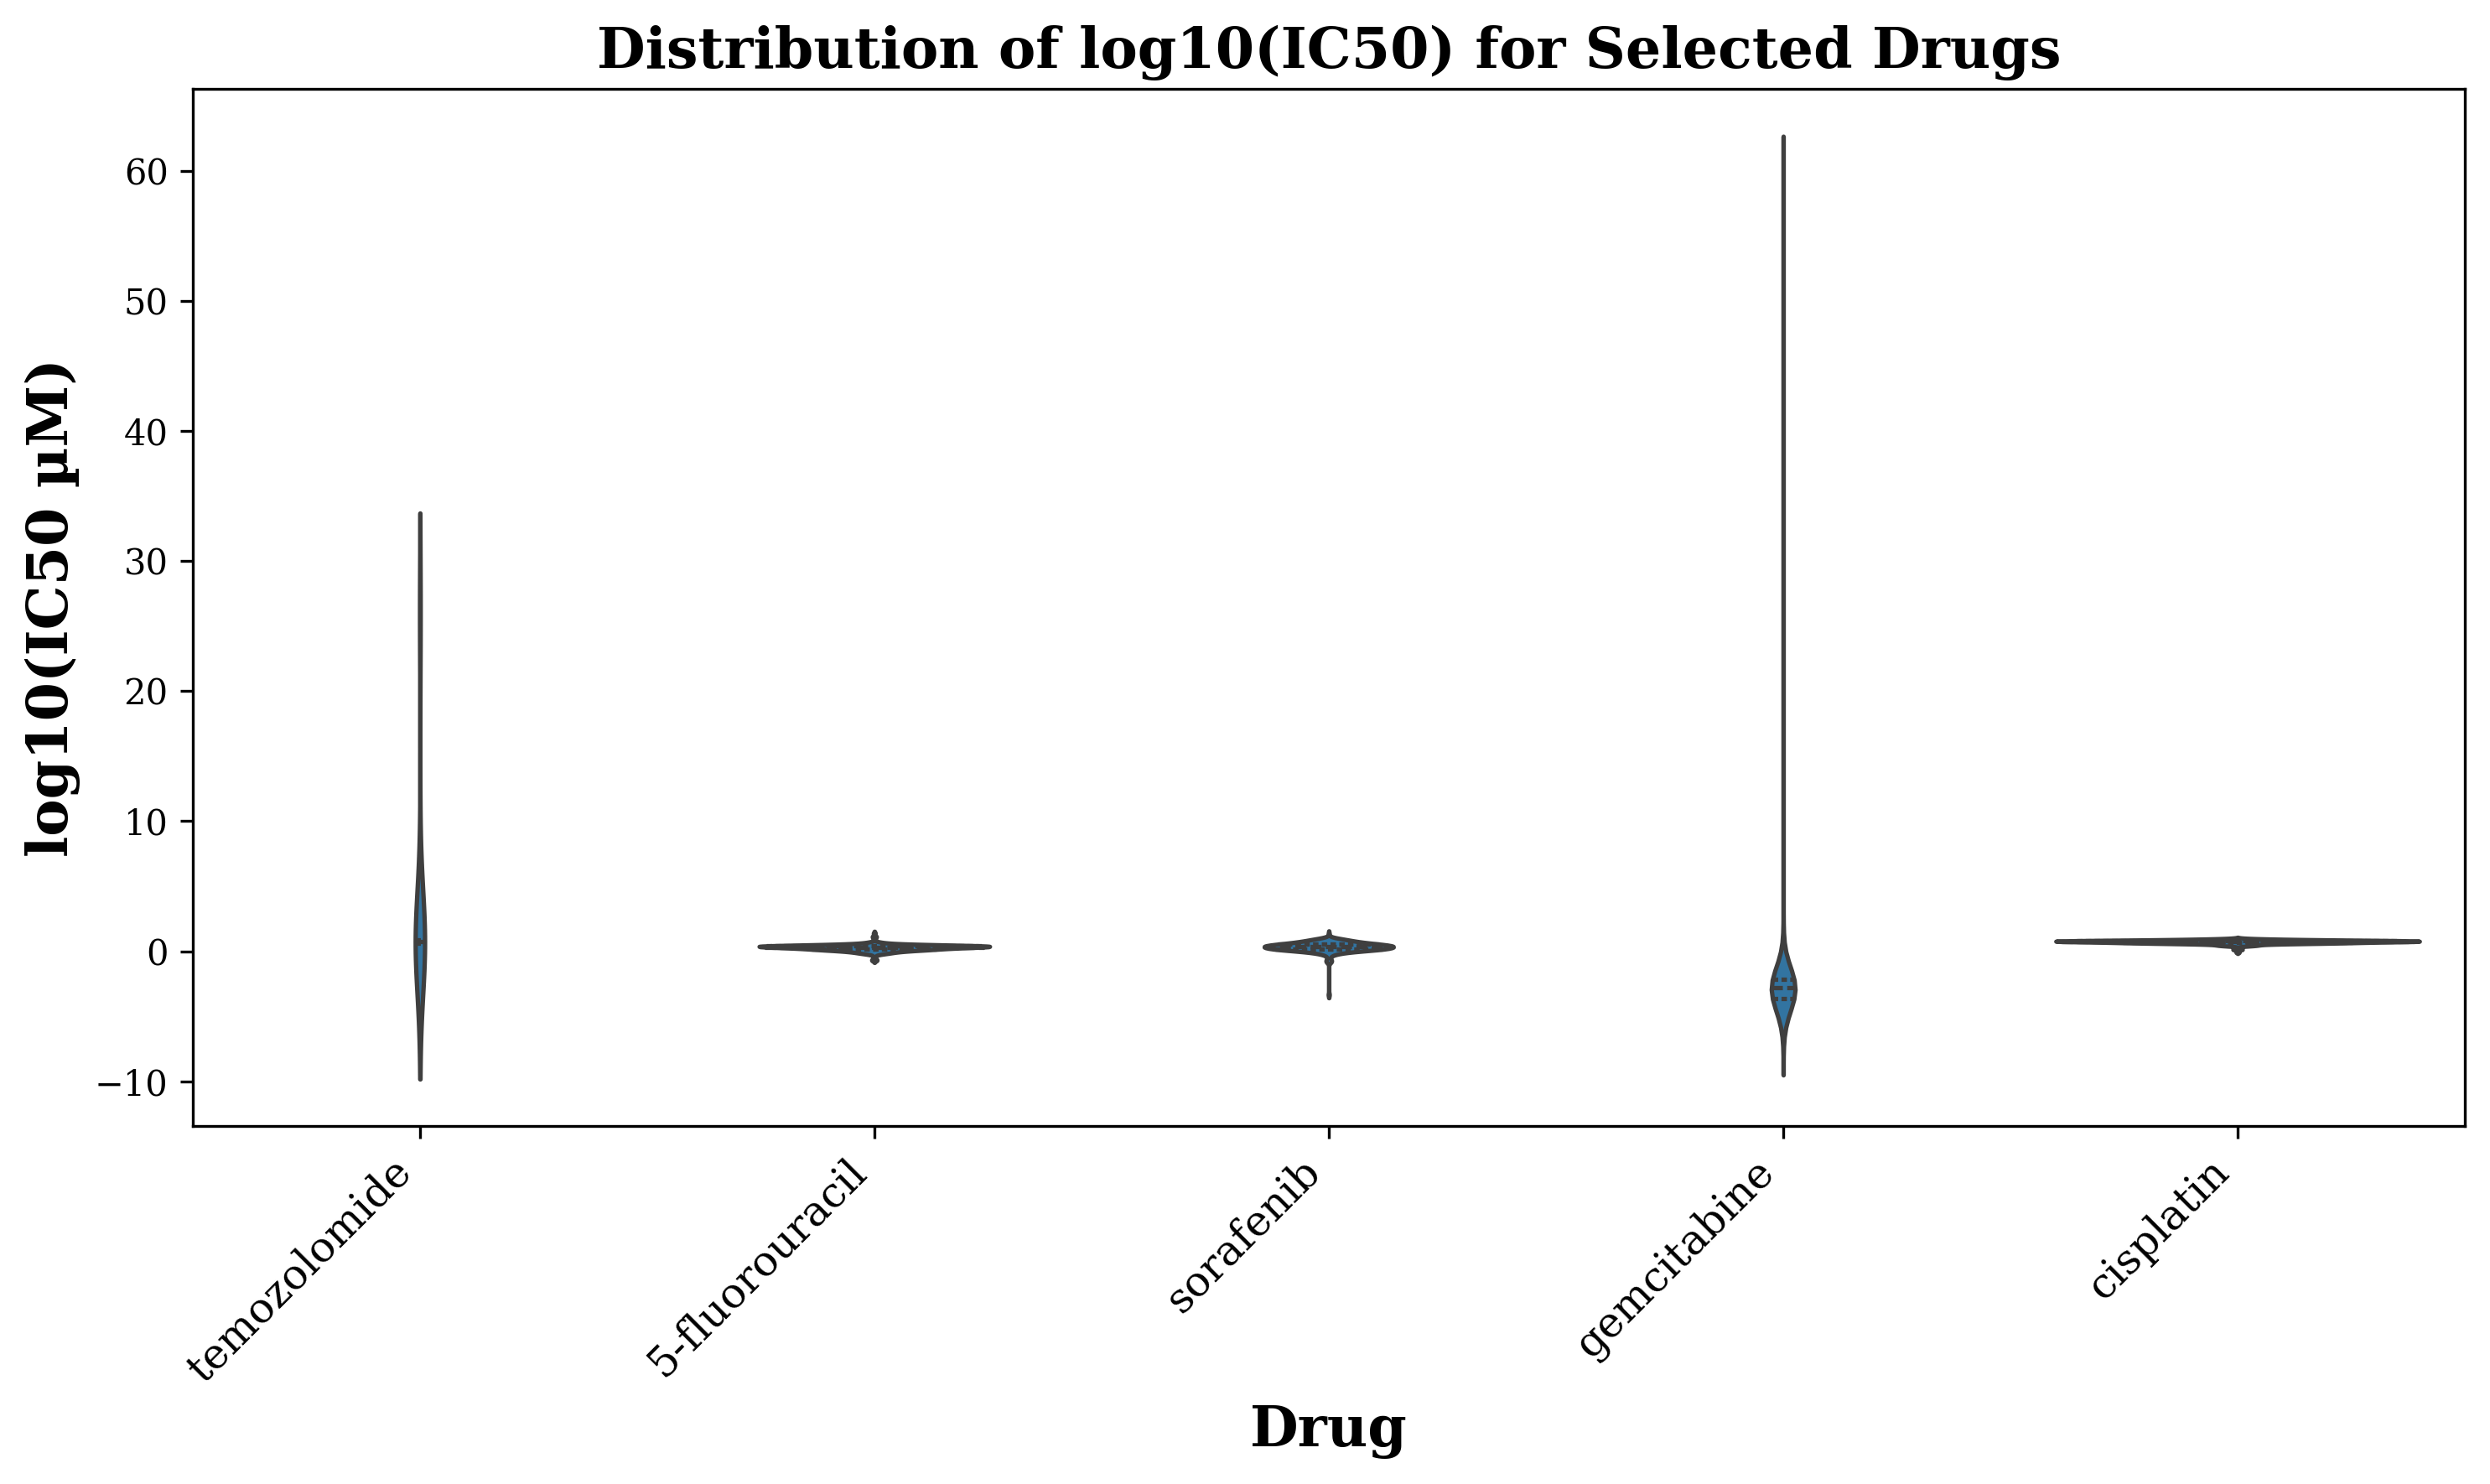

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set up high-quality rendering
# plt.style.use('seaborn')  # Better default style
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (15, 6)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
plot_df = df[df["name"].isin(drug_list)].copy()

plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x="name", y="logIC50", inner="quartile")
plt.title("Distribution of log10(IC50) for Selected Drugs", fontsize=16, fontweight='bold')
plt.xlabel("Drug", fontsize=16, fontweight='bold')
plt.ylabel("log10(IC50 µM)", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------- CONFIG -----------------------------
# Change these two paths to match your local file names.
CURVE_FILE = Path("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/secondary-screen-dose-response-curve-parameters.csv")
OUT_FILE   = Path("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/prism_lobico_AUDRC_per_drug.csv") # prism_lobico_thres_per_drug

# If you have AUC only, replace `ic50` below with your column name
# ---------------------------------------------------------------

def make_thres_candidates(response, n_points=200):
    """
    Generate ~n_points candidate thresholds τ between the 5th and 95th percentiles
    plus ±inf to mimic Knijnenburg's exhaustive search.
    """
    finite_vals = np.sort(response[np.isfinite(response)]) # Keep only finite logIC50 values and sort them.
    if finite_vals.size < 5:           # very sparse: just return uniques
        return np.unique(finite_vals)
    
    qs = np.quantile(finite_vals, np.linspace(0.05, 0.95, n_points))
    return np.unique(qs) # np.concatenate(([-np.inf], np.unique(qs), [np.inf]))

def weight_vec(response, thres, sigma=0.2, t=0.03):
    """
    Knijnenburg weighting: w_i = max(|x_i - τ| - t, 0) / σ
    """
    delta = np.abs(response - thres)
    return np.maximum(delta - t, 0.0) / sigma # sigma: scale parameter

def best_thres_for_one_drug(response_vec):
    """
    For a single drug, find τ* that minimises the weighted classification error
    when the classifier is a CONSTANT (K=0).
    Weighted error = min(total_weight_sensitive, total_weight_resistant)
    """
    best_thres, best_error = np.nan, np.inf
    for thres in make_thres_candidates(response_vec):
        y_bin = (response_vec <= thres).astype(int)          # 1 = sensitive
        w     = weight_vec(response_vec, thres)
        # total weight in each class
        sens_w = w[y_bin == 1].sum()
        res_w  = w[y_bin == 0].sum()
        error  = min(sens_w, res_w)                  # optimal constant prediction
        if error < best_error:
            best_error, best_thres = error, thres
    return best_thres, best_error

# -------------------- MAIN COMPUTATION -------------------------
print("Loading PRISM curve file ...")
df = pd.read_csv(CURVE_FILE)

# 1) clip extremely small / zero IC50
# df["ic50_clipped"] = df["ic50"].clip(lower=1e-300 ,upper=1e+300)#e-241, e+299
# df["logIC50"] = np.log10(df["ic50_clipped"])
# print(df["logIC50"].describe())
# df["logIC50"] = np.log10(df["ic50"].replace({np.inf: np.nan}))
print(f"Dataset loaded: {df.shape[0]:,} curve rows, {df['broad_id'].nunique()} unique drugs.")

results = []
for drug_id, sub in df.groupby("broad_id"):
    # print(f"Processing drug {drug_id} with {len(sub)} curves ...")
    # print(sub["logIC50"].values)
    thres_star, err = best_thres_for_one_drug(sub["auc"].values) # ["logIC50"]
    results.append({"broad_id": drug_id,
                    "threshold_auc": thres_star, # thres_star_log10
                    # "thres_star_uM": None if np.isinf(thres_star) else 10**thres_star,
                    "weighted_error": err,
                    "num_cell": len(sub)})
    if len(results) % 200 == 0:
        print(f"  processed {len(results)} drugs ...")

thres_df = pd.DataFrame(results)
thres_df.to_csv(OUT_FILE, index=False)
print(f"Done. τ* table written to {OUT_FILE.resolve()}")

Loading PRISM curve file ...


/tmp/ipykernel_44964/3101109475.py:52: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CURVE_FILE)


Dataset loaded: 701,004 curve rows, 1502 unique drugs.
  processed 200 drugs ...
  processed 400 drugs ...
  processed 600 drugs ...
  processed 800 drugs ...
  processed 1000 drugs ...
  processed 1200 drugs ...
  processed 1400 drugs ...
Done. τ* table written to /root/data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/prism_lobico_AUDRC_per_drug.csv


In [ ]:
df = pd.read_csv(CURVE_FILE)
thres_df = pd.read_csv("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/prism_lobico_AUDRC_per_drug.csv")
df  = df.merge(thres_df, on="broad_id")
df["label"] = (df["auc"] <= df["threshold_auc"]).astype(int) # Creates a binary label for each cell–drug pair:
df.to_csv("../../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/response_pair_label.csv", index=False)

/tmp/ipykernel_44964/1567345285.py:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CURVE_FILE)
